# 독립 표본 T-검정(이표본 검정, Independent two sample T-test)

서로 다른 두개의 그룹 간 평균의 차이가 유의미한지 여부를 판단한다.

데이터의 정규성과 등분산성을 만족해야 신뢰할 수 있는 결과를 얻을 수 있다.

## #01. 준비작업

### [1] 패키지 참조

`statannotations` 패키지가 필요하다

In [3]:
import warnings
warnings.filterwarnings(action='ignore')

import sys
import seaborn as sb
from math import sqrt
from pandas import read_excel, melt
from matplotlib import pyplot as plt
from scipy.stats import t, normaltest, bartlett, levene, ttest_ind
from statannotations.Annotator import Annotator

### [2] 그래프 초기화

In [4]:
plt.rcParams['font.family']='AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams['font.size']=12
plt.rcParams['figure.figsize']=(12,6)
plt.rcParams['axes.unicode_minus']=False

## #02. 예제(1) - 지혈제 효과 비교

### [1] 데이터 가져오기

두 종료의 지혈제 효과를 측정한 자료이다.

실험 참가자를 두 그룹으로 임의 분할한 후 피부에 작은 상처를 내어 피가 흐르게 한 다음, 한 그룹에는 지혈제 B를 다른 그룹에는 지혈제 G를 투여하여 완전히 지혈될 때 까지의 시간(분)을 측정하였다.

지혈제에 따른 지혈시간이 유의미한 차이가 있는지 확인하라.

단, 모든 데이터는 정규성을 충족한다고 가정한다.

In [5]:
origin = read_excel('C:/Users/Jihwan/01Class/E.추론통계/수업자료/styptic.xlsx')
origin

,B,G
0,8.80,9.9
1,8.90,10.0
2,8.40,9.0
3,7.90,11.1
4,8.20,9.8
5,8.70,9.6
6,7.90,10.3
7,9.10,8.7
8,9.60,10.4
9,8.75,9.5


### [2] 신뢰구간 확인

두 그룹의 데이터 분포와 신뢰구간을 확인한다.

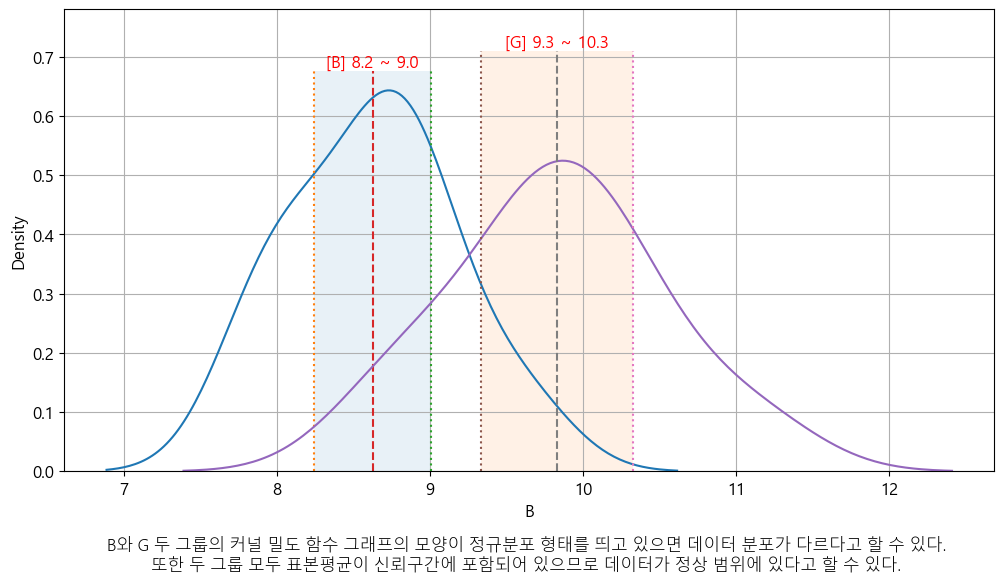

In [6]:
plt.figure()

for c in origin.columns:
    #print(c)

    data = origin[c]
    max = data.max()
    clevel=0.95
    dof=len(data)-1
    sample_mean = data.mean()
    sample_std = data.std(ddof=1)
    sample_std_error = sample_std / sqrt(len(data))

# 신뢰구간
    
    cmin, cmax = t.interval(clevel, dof, loc=sample_mean, scale=sample_std_error)

    sb.kdeplot(data=data)

    xmin, xmax, ymin, ymax = plt.axis()

    # 신뢰구간 그리기

    plt.plot([cmin,cmin],[ymin,ymax],linestyle=':')
    plt.plot([cmax,cmax],[ymin,ymax],linestyle=':')
    plt.fill_between([cmin,cmax],y1=0,y2=ymax,alpha=0.1)

    # 평균 그리기
    plt.plot([sample_mean,sample_mean],[0,ymax],linestyle='--')

    plt.text(x=(cmax-cmin)/2+cmin,
             y=ymax,
             s='[%s] %0.1f ~ %0.1f' % (c,cmin,cmax),
             horizontalalignment='center',
             verticalalignment='bottom',
             fontdict={'size':12,'color':'red'})
    
plt.ylim(ymin,ymax*1.1)

txt = """B와 G 두 그룹의 커널 밀도 함수 그래프의 모양이 정규분포 형태를 띄고 있으면 데이터 분포가 다르다고 할 수 있다.
또한 두 그룹 모두 표본평균이 신뢰구간에 포함되어 있으므로 데이터가 정상 범위에 있다고 할 수 있다."""

plt.figtext(0.51,0,txt,wrap=True,
            verticalalignment='top', horizontalalignment='center',
            fontdict={'size':12,'weight':'light'})

plt.grid()
plt.show()
plt.close()



### [3] 가설검정의 가정 확인

#### (1) 정규성

In [7]:
for c in origin.columns:
    s, p = normaltest(origin[c])
    print('[{0}] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}'.format(c,s,p,p>0.05))
    

[B] statistic: 0.083, p-value: 0.959, 정규성 충족 여부: True
[G] statistic: 0.201, p-value: 0.904, 정규성 충족 여부: True


#### (2) 등분산성

In [14]:
normal_dist = True
data = origin.copy()
fields = list(map(lambda x: data[x], data.columns))

if normal_dist:
    n = 'bartlett'
    s, p = bartlett(*fields)

else:
    n = 'levene'
    s, p = levene(*fields)

print('{0}검정: statistic: {1:.3f}, p-value:{2:.3f}, 등분산성 충족 여부: {3}'.format(n,s,p,p > 0.05))

bartlett검정: statistic: 0.556, p-value:0.456, 등분산성 충족 여부: True


### [4] 두 그룹간 지혈 시간 평균에 차이가 있는지 검정

| 구분 | 수식 | 내용 |
|---|---|---|
| B 그룹의 평균 | $\mu(B)$ | |
| G 그룹의 평균 | $\mu(G)$ | |
| 귀무가설($H_0$) | $\mu(B) = \mu(G)$ | 두 그룹의 지혈 시간 평균은 차이가 없다. |
| 대립가설($H_1$) | $\mu(B) \neq \mu(G)$ | 두 그룹의 지혈 시간 평균은 차이가 있다. |

두 그룹간의 평균을 비교하기 위해서는 `ttest_ind` 메서드를 사용한다.

`alternative` 파라미터에 따라 비교 내용이 달라진다.

내용은 대립가설에 따라 결정된다.

| 값 | 설명 |
|---|---|
| `two-sided` | 두 그룹의 평균이 같은지를 판단한다(기본값) |
| `greater` | 두 그룹중 첫 번째 그룹의 평균이 더 큰지 판단한다. |
| `less` | 두 그룹중 첫 번째 그룹의 평균이 더 작은지 판단한다. |

In [15]:
s, p = ttest_ind(origin['B'],origin['G'])
'statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택'.format(s,p,'대립' if p <= 0.05 else '귀무')

'statistic: -4.350, p-value: 0.000, 대립가설 채택'

p-value가 0.05보다 작으므로 귀무가설을 기각하고 대립가설을 채택한다. 두 그룹 간의 평균은 차이가 있다. 

> `p-value`가 0.05보다 작으므로($p < 0.05$) 지혈제 B를 사용한 그룹과 지혈제 G를 사용한 그룹간 평균 지혈시간에는 차이가 있다.

### [5] `B`그룹의 평균이 `G`그룹 평균보다 더 큰지 검정

| 구분 | 수식 | 내용 |
|---|---|---|
| 귀무가설($H_0$) | $\mu(B) \leq \mu(G)$ | 지혈제 B를 사용한 그룹의 평균 지혈시간은 G를 사용한 그룹의 평균 지혈시간보다 크지 않다. |
| 대립가설($H_1$) | $\mu(B) > \mu(G)$ | 지혈제 B를 사용한 그룹의 평균 지혈시간은 G를 사용한 그룹의 평균 지혈시간보다 크다. |

In [16]:
s, p = ttest_ind(origin['B'],origin['G'],alternative='greater')
'statistic: {0:.3f}, p-value:{1:.3f}, {2}가설 채택'.format(s,p,'대립' if p <= 0.05 else '귀무')

'statistic: -4.350, p-value:1.000, 귀무가설 채택'

> `p-value`가 `0.05`보다 크므로($P \geq 0.05$) 지혈제 B를 사용한 그룹의 평균 지혈 시간은 지혈제 G를 사용한 그룹의 평균 지혈시간보다 크지 않다는 귀무가설을 기각할 수 없다.

### [6] `B`그룹의 평균이 `G`그룹 평균보다 더 작은지 검정

| 구분 | 수식 | 내용 |
|---|---|---|
| 귀무가설($H_0$) | $\mu(B) \geq \mu(G)$ | 지혈제 B를 사용한 그룹의 평균 지혈시간은 G를 사용한 그룹의 평균 지혈시간보다 작지 않다. |
| 대립가설($H_1$) | $\mu(B) < \mu(G)$ | 지혈제 B를 사용한 그룹의 평균 지혈시간은 G를 사용한 그룹의 평균 지혈시간보다 작다. |

In [17]:
s, p = ttest_ind(origin['B'],origin['G'],alternative='less')
'statistic: {0:.3f}, p-value:{1:.3f}, {2}가설 채택'.format(s,p,'대립' if p <= 0.05 else '귀무')

'statistic: -4.350, p-value:0.000, 대립가설 채택'

> `p-value`가 0.05보다 작으므로($P < 0.05$) 귀무가설을 기각하고 대립가설을 채택한다.
>
> 즉, 지혈제 B를 사용한 그룹의 평균 지혈 시간은 지혈제 G를 사용한 그룹의 평균 지혈시간 작다.

### [6] 가설검정 시각화

`statannotations` 패키지의 `Annotator` 클래스는 `seaborn`으로 구현한 그래프에 설명을 추가하는 기능을 제공한다.

가설검정에 대해서는 영가설이 $\mu(B) = \mu(G)$ 인 경우만 지원되고 작다, 크다에 대한 경우는 제공되지 않는다.

#### (1) 데이터 전처리

`hue` 파라미터를 적용할 수 있는 형태로 데이터 재배치가 필요하다.

In [12]:
df = melt(origin,var_name='group',value_name='value')
df

,group,value
0,B,8.80
1,B,8.90
2,B,8.40
3,B,7.90
4,B,8.20
5,B,8.70
6,B,7.90
7,B,9.10
8,B,9.60
9,B,8.75


#### (2) 시각화 구현

| 파라미터 | 설명 |
|---|---|
| ax | boxplot 객체 |
| data | 데이터프레임 |
| x | 명목형 변수 |
| y | 연속형 변수 |
| pairs | 비교 대상을 묶은 리스트 |
| test | 가설검정 알고리즘 종류 (`t-test_ind`, `t-test_paired`, `t-test_welch`, `Mann-Whitney`, `Mann-Whitney-gt`, `Mann-Whitney-ls`, `Levene`, `Wilcoxon`, `Kruskal` 등을 지원함) |
| text_format | 출력 형식 (`full`, `simple`, `star`)를 지원함 |

ValueError: Missing x value(s) `"B", "G"` in group (specified in `pairs`) in data

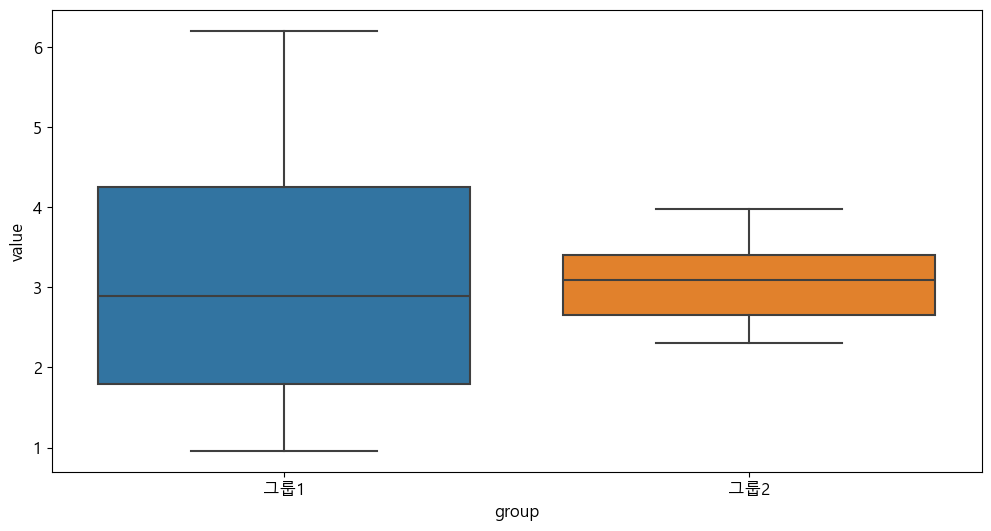

In [31]:
plt.figure()
ax = sb.boxplot(data=df, x='group', y='value')

annotator = Annotator(ax, data=df, x='group', y='value', pairs=[('B','G')])
annotator.configure(test='t-test_ind', text_format='star', loc='inside')
annotator.apply_and_annotate()

sb.despine()
plt.show()
plt.close()

In [18]:
origin = read_excel('C:/Users/Jihwan/01Class/E.추론통계/수업자료/heatrate.xlsx')
origin

,그룹1,그룹2
0,3.84,3.97
1,2.60,2.50
2,1.19,2.70
3,2.00,3.36
4,6.20,3.55
5,0.96,2.97
6,5.50,3.20
7,3.18,2.30


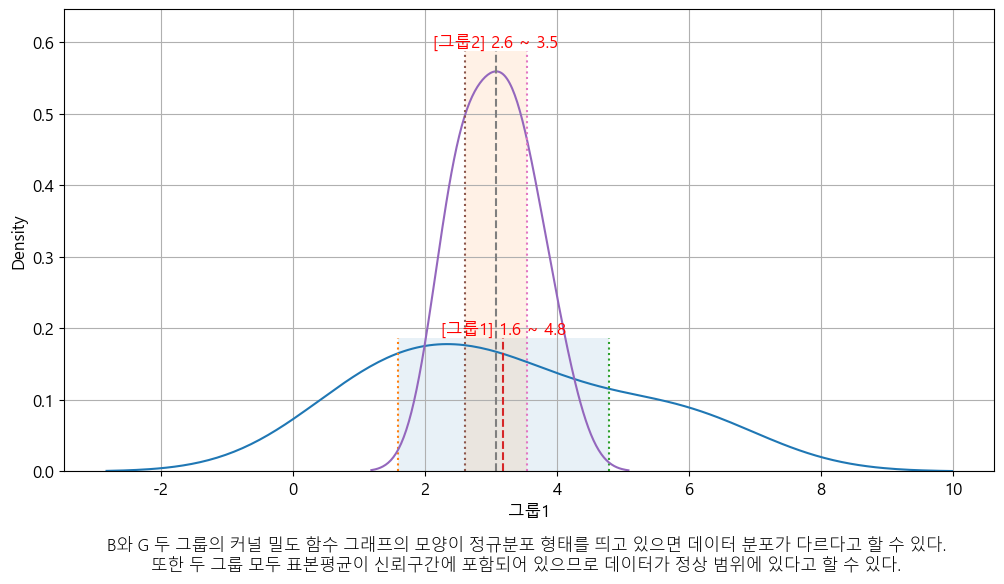

In [19]:
plt.figure()

for c in origin.columns:
    #print(c)

    data = origin[c]
    max = data.max()
    clevel=0.95
    dof=len(data)-1
    sample_mean = data.mean()
    sample_std = data.std(ddof=1)
    sample_std_error = sample_std / sqrt(len(data))

# 신뢰구간
    
    cmin, cmax = t.interval(clevel, dof, loc=sample_mean, scale=sample_std_error)

    sb.kdeplot(data=data)

    xmin, xmax, ymin, ymax = plt.axis()

    # 신뢰구간 그리기

    plt.plot([cmin,cmin],[ymin,ymax],linestyle=':')
    plt.plot([cmax,cmax],[ymin,ymax],linestyle=':')
    plt.fill_between([cmin,cmax],y1=0,y2=ymax,alpha=0.1)

    # 평균 그리기
    plt.plot([sample_mean,sample_mean],[0,ymax],linestyle='--')

    plt.text(x=(cmax-cmin)/2+cmin,
             y=ymax,
             s='[%s] %0.1f ~ %0.1f' % (c,cmin,cmax),
             horizontalalignment='center',
             verticalalignment='bottom',
             fontdict={'size':12,'color':'red'})
    
plt.ylim(ymin,ymax*1.1)

txt = """B와 G 두 그룹의 커널 밀도 함수 그래프의 모양이 정규분포 형태를 띄고 있으면 데이터 분포가 다르다고 할 수 있다.
또한 두 그룹 모두 표본평균이 신뢰구간에 포함되어 있으므로 데이터가 정상 범위에 있다고 할 수 있다."""

plt.figtext(0.51,0,txt,wrap=True,
            verticalalignment='top', horizontalalignment='center',
            fontdict={'size':12,'weight':'light'})

plt.grid()
plt.show()
plt.close()



In [20]:
for c in origin.columns:
    s, p = normaltest(origin[c])
    print('[{0}] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}'.format(c,s,p,p>0.05))
    

[그룹1] statistic: 0.840, p-value: 0.657, 정규성 충족 여부: True
[그룹2] statistic: 0.261, p-value: 0.878, 정규성 충족 여부: True


In [21]:
normal_dist = True
data = origin.copy()
fields = list(map(lambda x: data[x], data.columns))

if normal_dist:
    n = 'bartlett'
    s, p = bartlett(*fields)

else:
    n = 'levene'
    s, p = levene(*fields)

print('{0}검정: statistic: {1:.3f}, p-value:{2:.3f}, 등분산성 충족 여부: {3}'.format(n,s,p,p > 0.05))

bartlett검정: statistic: 8.029, p-value:0.005, 등분산성 충족 여부: False


In [23]:
s, p = ttest_ind(origin['그룹1'],origin['그룹2'], alternative='two-sided', equal_var=False)
'statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택'.format(s,p,'대립' if p <= 0.05 else '귀무')

'statistic: 0.163, p-value: 0.874, 귀무가설 채택'

In [24]:
s, p = ttest_ind(origin['그룹1'],origin['그룹2'], alternative='greater', equal_var=False)
'statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택'.format(s,p,'대립' if p <= 0.05 else '귀무')

'statistic: 0.163, p-value: 0.437, 귀무가설 채택'

In [25]:
s, p = ttest_ind(origin['그룹1'],origin['그룹2'], alternative='less', equal_var=False)
'statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택'.format(s,p,'대립' if p <= 0.05 else '귀무')

'statistic: 0.163, p-value: 0.563, 귀무가설 채택'

In [26]:
df = melt(origin, var_name='group', value_name='value')
df

,group,value
0,그룹1,3.84
1,그룹1,2.60
2,그룹1,1.19
3,그룹1,2.00
4,그룹1,6.20
5,그룹1,0.96
6,그룹1,5.50
7,그룹1,3.18
8,그룹2,3.97
9,그룹2,2.50


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

그룹1 vs. 그룹2: t-test independent samples, P_val:8.726e-01 t=1.633e-01


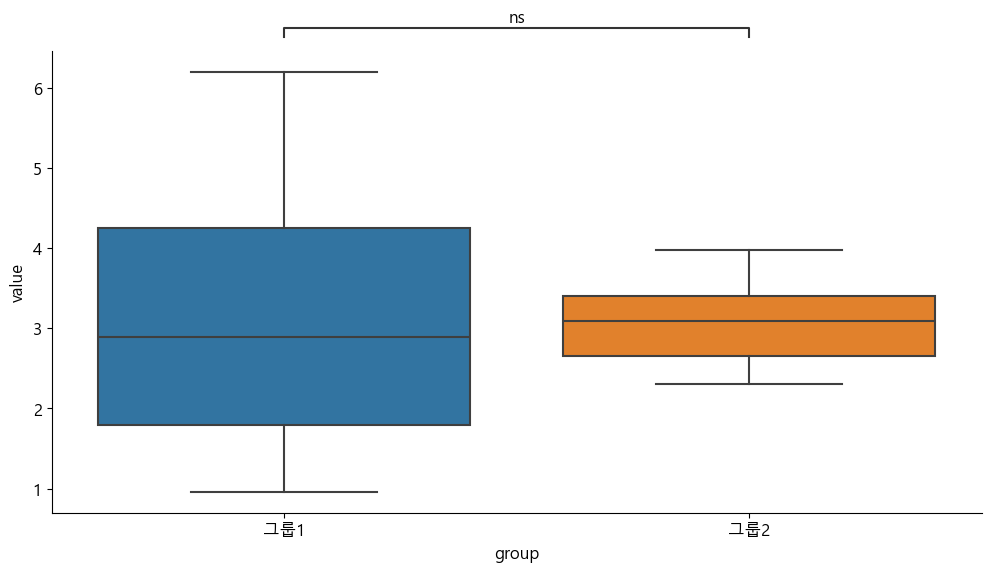

In [30]:
config = {
    'data': df,
    'x': 'group',
    'y': 'value',
    'pairs': [('그룹1','그룹2')],
    'test':'t-test_ind',
    'text_format':'star',
    'loc':'outside'

}

plt.figure()
ax = sb.boxplot(data=config['data'],x=config['x'],y=config['y'])
ax.get_xaxis().axis_name

annotator = Annotator(ax, data=config['data'],x = config['x'], y = config['y'], pairs=config['pairs'])
annotator.configure(test=config['test'],text_format=config['text_format'],loc=config['loc'])
annotator.apply_and_annotate()

sb.despine()
plt.show()
plt.close()
